In [258]:
from sklearn.cluster import KMeans
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

## Data Loading

In [259]:
biomass_density = pd.read_csv('preprocessed/forecasted.csv')

In [260]:
distance_matrix = pd.read_csv('dataset/Distance_Matrix.csv')

In [261]:
distance_matrix = distance_matrix.drop('Unnamed: 0',axis=1)

In [262]:
biomass_density = biomass_density.drop('Unnamed: 0',axis=1)

In [263]:
distance_matrix.shape

(2418, 2418)

## Prprocessing

In [264]:
#new_distance = lambda den,dist: den/dist

In [265]:
biomass_density.head()

,Latitude,Longitude,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,24.66818,71.33144,0.212466,0.225726,0.219358,0.169677,0.231301,0.205046,0.243113,0.180307,0.199934,0.502740
1,24.66818,71.41106,0.300711,0.333306,0.309579,0.259861,0.340509,0.328613,0.428428,0.362593,0.334189,0.518164
2,24.66818,71.49069,0.370192,0.440955,0.402816,0.350319,0.433291,0.380620,0.486443,0.435923,0.397611,0.511109
3,24.66818,71.57031,0.407901,0.471496,0.449079,0.371401,0.475138,0.449872,0.525324,0.485404,0.437328,0.541641
4,24.66818,71.64994,0.255002,0.292657,0.292995,0.243953,0.281919,0.291840,0.317984,0.309058,0.257460,0.509233


In [266]:
distance_matrix.head()

,0,1,2,3,4,5,6,7,8,9,...,2408,2409,2410,2411,2412,2413,2414,2415,2416,2417
0,0.0000,11.3769,20.4557,38.1227,45.3810,54.9915,78.6108,118.6750,102.6639,113.4309,...,683.8771,687.6310,697.3246,669.3962,667.6788,665.5775,662.0291,665.9655,673.2073,681.4235
1,11.3769,0.0000,9.0788,28.9141,36.1724,45.7829,69.4022,78.2329,93.4553,111.1832,...,681.6295,685.3833,695.0769,667.1485,665.4311,663.3298,659.7815,663.7178,670.9596,679.1758
2,20.4557,9.0788,0.0000,22.3791,29.6374,39.2478,62.8671,71.6979,86.9203,111.7859,...,682.2323,685.9861,695.6796,667.7513,666.0339,663.9326,660.3843,664.3206,671.5623,679.7786
3,38.1227,28.9141,22.3791,0.0000,11.8343,23.5413,41.8396,50.6703,65.8927,82.5852,...,681.4226,685.1765,694.8701,666.9417,665.2243,663.1230,659.5746,663.5110,670.7528,678.9690
4,45.3810,36.1724,29.6374,11.8343,0.0000,11.7070,24.3986,33.2293,53.9901,65.1442,...,663.9816,667.7355,677.4291,649.5007,647.7833,645.6820,642.1336,646.0700,653.3118,661.5280


## Modelling

In [267]:
year = '2018'

### Get initial point with most density of biomass

In [268]:
def get_most(column_name):
    density=biomass_density[column_name]
    return np.argmax(density)
    

### Get pobability based on biomass density

In [269]:
k=10

In [270]:
def set_prob_depots(density):
    sum_density=sum(density)
    prob=[x/sum_density for x in density]
    return prob

In [271]:
weights=set_prob_depots(biomass_density[year])

In [272]:
def get_depots(k,column_name,weights):
    depots=[]
    while len(depots)!=k :
        depots = np.random.choice(biomass_density[column_name].shape[0],size=k,p=weights)
    return depots

In [273]:
biomass_density[year].shape[0]

2418

In [274]:
depots = get_depots(k,year,weights)

### Visualising Data

In [275]:
def plot_depots(depots,clusters=None,refineries=None):
    depots_location = biomass_density.loc[depots, ["Latitude", "Longitude"]]

    latitudes = biomass_density["Latitude"]
    longitudes = biomass_density["Longitude"]

    # Create a scatter plot
    plt.scatter(latitudes, longitudes,c=clusters)
    if(refineries!=None):
        refineries_location = biomass_density.loc[refineries, ["Latitude", "Longitude"]]
        plt.scatter(refineries_location['Latitude'],refineries_location['Longitude'],marker='o', color='white')
    
    plt.scatter(depots_location["Latitude"], depots_location["Longitude"], marker='x', color='red')

    # Add a title and labels
    plt.title('Latitude and Longitude')
    plt.xlabel('Latitude')
    plt.ylabel('Longitude')

    # Show the plot
    plt.show()

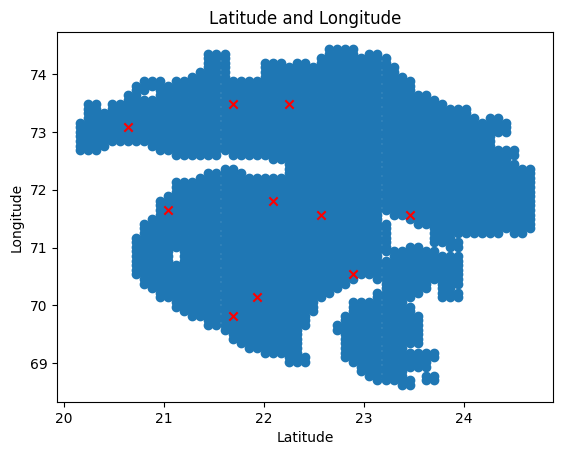

In [276]:
plot_depots(depots)

## Optimal clusters for depots

In [277]:
def re_cluster_depots(k,X,depots):
    belonging_to_cluster=np.array([])
    for i in range(X.shape[0]):
        distance=[distance_matrix.iloc[i,x] for x in depots]
        belonging_to_cluster=np.append(belonging_to_cluster,np.argmin(distance))

    depots = []
    for i in range(k):
        pseudo_coord = np.mean(X[belonging_to_cluster==i][['Latitude','Longitude']].to_numpy(),axis=0)
        distance = [np.linalg.norm(pseudo_coord - x) for x in X[belonging_to_cluster==i][['Latitude','Longitude']].to_numpy()]
        depots.append(X[belonging_to_cluster==i].iloc[np.argmin(distance),:].name)
        
    return depots,belonging_to_cluster

In [278]:
count=0
clusters=[]
for _ in range(30):
    prev=depots
    depots,clusters=re_cluster_depots(k,biomass_density,depots)
    if np.array_equal(prev,depots):
        break
    print(depots)
    count+=1
print(f"Convergence in : {count} iterations")

[1592, 2170, 1634, 218, 653, 1790, 1073, 1104, 1885, 2321]
[1651, 2127, 1515, 219, 589, 1736, 1018, 995, 1832, 2321]
[1707, 2126, 1455, 180, 588, 1736, 1018, 996, 1777, 2322]
[1707, 2125, 1393, 180, 588, 1736, 955, 935, 1778, 2322]
[1707, 2124, 1262, 180, 588, 1682, 956, 936, 1778, 2322]
[1707, 2124, 1263, 179, 588, 1682, 956, 936, 1778, 2322]
[1707, 2124, 1263, 179, 588, 1682, 956, 937, 1778, 2322]
[1707, 2124, 1204, 179, 588, 1682, 956, 938, 1778, 2322]
[1707, 2124, 1205, 179, 588, 1682, 956, 939, 1778, 2322]
[1707, 2124, 1149, 179, 588, 1683, 957, 877, 1778, 2322]
[1707, 2123, 1149, 179, 588, 1682, 957, 878, 1778, 2322]
[1707, 2123, 1150, 153, 588, 1627, 957, 878, 1778, 2322]
[1707, 2123, 1150, 152, 587, 1627, 957, 878, 1778, 2322]
[1707, 2123, 1041, 151, 646, 1627, 957, 814, 1778, 2322]
[1707, 2123, 923, 151, 646, 1628, 957, 749, 1778, 2322]
[1707, 2123, 860, 151, 645, 1628, 958, 749, 1778, 2322]
[1651, 2123, 860, 151, 645, 1629, 958, 749, 1777, 2322]
[1651, 2123, 795, 151, 645, 16

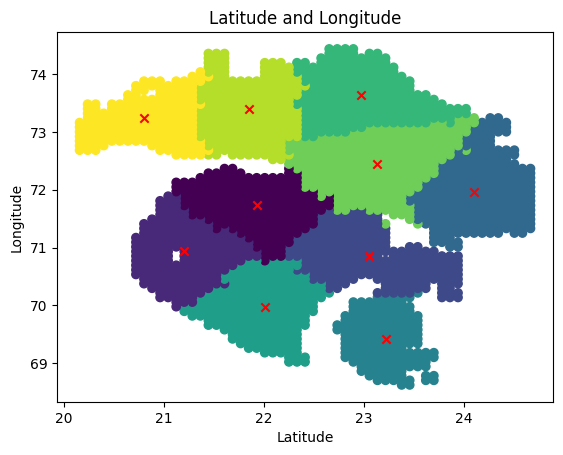

In [279]:
plot_depots(depots,clusters)

## Finding refineries

In [280]:
biomass_density

,Latitude,Longitude,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,24.66818,71.33144,0.212466,0.225726,0.219358,0.169677,0.231301,0.205046,0.243113,0.180307,0.199934,0.502740
1,24.66818,71.41106,0.300711,0.333306,0.309579,0.259861,0.340509,0.328613,0.428428,0.362593,0.334189,0.518164
2,24.66818,71.49069,0.370192,0.440955,0.402816,0.350319,0.433291,0.380620,0.486443,0.435923,0.397611,0.511109
3,24.66818,71.57031,0.407901,0.471496,0.449079,0.371401,0.475138,0.449872,0.525324,0.485404,0.437328,0.541641
4,24.66818,71.64994,0.255002,0.292657,0.292995,0.243953,0.281919,0.291840,0.317984,0.309058,0.257460,0.509233
...,...,...,...,...,...,...,...,...,...,...,...,...
2413,20.15456,72.84432,0.180534,0.180260,0.170496,0.129193,0.180347,0.190154,0.231986,0.181932,0.177813,0.534950
2414,20.15456,72.92394,0.051700,0.054713,0.048782,0.044817,0.051860,0.054145,0.065674,0.051462,0.048789,0.564789
2415,20.15456,73.00357,0.035414,0.037422,0.033379,0.030625,0.035525,0.037108,0.044995,0.035245,0.034098,0.564997
2416,20.15456,73.08319,0.145447,0.121111,0.097915,0.099246,0.114721,0.119751,0.145269,0.113851,0.120770,0.528472


In [281]:
def biomass_per_depot(k,clusters,year):
    biomass=[]
    for i in range(k):
        biomass.append(sum(biomass_density[clusters==i][year]))
    return biomass

In [282]:
biomass_per_depot=biomass_per_depot(k,clusters,year)
biomass_per_depot

[147.00862846500004,
 128.92377077199995,
 130.036857933,
 119.69695746600003,
 39.190736080299985,
 138.33499130100003,
 103.81896011100002,
 176.96659164499994,
 122.02195154999998,
 68.89419982000001]

In [283]:
depots

[1651, 2123, 795, 151, 645, 1570, 895, 749, 1723, 2322]

In [284]:
r=5

In [285]:
def set_prob_ref(density):
    sum_density = sum(density)
    prob = [x/sum_density for x in density]
    return prob

In [286]:
weights=set_prob_ref(biomass_per_depot)
weights

[0.1251250520187039,
 0.10973229049704776,
 0.1106796844723248,
 0.10187897258683425,
 0.03335683722718574,
 0.11774256493159217,
 0.08836456009457552,
 0.15062349888139498,
 0.10385787007565024,
 0.05863866921469056]

In [287]:
def get_refineries(r,depots,weights):
    if len(weights)<r:
        r = len(weights)
    refineries_index = np.random.choice(len(weights),size=r,p=weights)
    refineries = []
    for i in refineries_index:
        refineries.append(depots[i])
    return refineries

In [288]:
refineries = get_refineries(r,depots,weights)
refineries

[1651, 1570, 795, 749, 1723]

## Optimal clusters for refineries

In [289]:
def re_cluster_refineries(r,X,refineries):
    belonging_to_cluster=np.array([])
    for i in X:
        distance = [distance_matrix.iloc[i,x] for x in refineries]
        belonging_to_cluster = np.append(belonging_to_cluster,np.argmin(distance))
    
    X=np.array(X)
    refineries = []
    for i in range(r):
        pseudo_coord = np.mean(biomass_density.iloc[X[belonging_to_cluster==i],[0,1]].to_numpy(),axis=0)
        distance = [np.linalg.norm(pseudo_coord - x) for x in biomass_density.iloc[:,[0,1]].to_numpy()]
        refineries.append(biomass_density.iloc[np.argmin(distance),:].name)
    return refineries,belonging_to_cluster

In [290]:
count=0
clusters_depots=[]
for _ in range(30):
    prev=refineries
    refineries,cluster_depots=re_cluster_refineries(r,depots,refineries)
    if np.array_equal(prev,refineries):
        break
    print(refineries)
    count+=1
print(f"Convergence in : {count} iterations")

[1919, 1570, 722, 557, 2052]
Convergence in : 1 iterations


In [291]:
def biomass_per_refineries(r,cluster_depots,biomass_per_depot):
    biomass=[]
    biomass_per_depot=np.array(biomass_per_depot)
    for i in range(r):
        biomass.append(sum(biomass_per_depot[cluster_depots==i]))
    return biomass

In [292]:
biomass_per_refinery = biomass_per_refineries(r,cluster_depots,biomass_per_depot)

In [293]:
plot_depots(depots,clusters,refineries)

KeyboardInterrupt: 

## Loss function for depots

In [250]:
biomass_per_depot

[40.888227070299976,
 127.27404404200001,
 121.351590214,
 73.06152940399996,
 124.39143850999996,
 129.383622269,
 153.70653814500005,
 136.32831927499996,
 158.989699629,
 109.51863658499997]

In [294]:
biomass_per_refinery

[275.932399237,
 138.33499130100003,
 169.22759401329998,
 400.482509222,
 190.91615137]

In [295]:
clusters

array([3., 3., 3., ..., 9., 9., 9.])

In [296]:
cluster_depots

array([0., 0., 2., 3., 2., 1., 3., 3., 4., 4.])

In [301]:
depots

[1651, 2123, 795, 151, 645, 1570, 895, 749, 1723, 2322]

In [302]:
refineries

[1919, 1570, 722, 557, 2052]

In [335]:
def loss_depot(depots,year):
    loss=[]
    for i in range(len(depots)):
        loss.append(sum(biomass_density.loc[x,year]*distance_matrix.iloc[x,depots[i]] for x in biomass_density[clusters==i].index))
    print(loss)
    return sum(loss)

In [ ]:
def loss_refinery(refineries,cluster_depots):
    loss=[]
    for i in range(len(refineries)):
        loss.append(sum())

In [336]:
loss_depot(depots,year)

[10708.331827645492, 9712.781360731153, 9397.626721181432, 8342.996058721497, 2191.4446696674436, 10474.902712493747, 7672.31228783576, 13678.955441878947, 9326.811614426955, 4571.784681409451]


86077.94737599188